# Fix pathing

In [ ]:
import sys


sys.path.append("..")


In [ ]:
import constants

import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))


## Imports

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Init

In [ ]:
import datahandler
import utils


dataset_id = "oslo"

data_preprocessor = datahandler.DataPreprocessorOUS(dataset_id)
data_preprocessor.execute()

data_loader = datahandler.DataLoader(dataset_id)
data_loader.execute()


# Plot

In [ ]:
rows_df1 = data_loader.processed_incidents_df.shape[0]
rows_df2 = data_loader.enhanced_incidents_df.shape[0]
rows_dropped = rows_df1 - rows_df2
drop_percentage = (rows_dropped / rows_df1) * 100

labels = ["Original", "Cleaned"]
values = [rows_df1, rows_df2]

fig, ax = plt.subplots()
ax: plt.Axes = ax

bars = ax.bar(labels, values, color=["blue", "green"])
# adjust y-axis limits to provide space for the legend
ax.set_ylim(0, max(values) * 1.35)
# add details to legend
handles, labels = ax.get_legend_handles_labels()
labels.append(f"Original: {rows_df1:,}")
labels.append(f"Cleaned: {rows_df2:,}")
labels.append(f"Rows Dropped: {rows_dropped:,}")
labels.append(f"Percentage Dropped: {drop_percentage:.2f}%")
# assigning specific colors for the legend placeholders
handles.extend([
    plt.Line2D([0], [0], color="blue"),
    plt.Line2D([0], [0], color="green"),
    plt.Line2D([0], [0], color="black"),
    plt.Line2D([0], [0], color="red")
])

ax.legend(handles=handles, labels=labels)

plt.ylabel("Incidents")
plt.title("Comparison of Total Incidents Before and After Cleaning")
plt.show()


In [ ]:
df = utils.copy_dataframe(data_loader.processed_incidents_df)
original_count = df.shape[0]

rows_remaining = []
rows_dropped = []
labels = []
# step 0
rows_remaining.append(df.shape[0])
rows_dropped.append(original_count - df.shape[0])
labels.append("Original dataset")
# step 1
df.dropna(subset=["time_available", "time_dispatch", "triage_impression_during_call", "time_ambulance_notified", "region"], inplace=True)

rows_remaining.append(df.shape[0])
rows_dropped.append(original_count - df.shape[0])
labels.append("Drop rows missing critical timestamps or triage")
# step 2
mask1 = df["time_arrival_scene"].isna() & df["time_arrival_hospital"].notna()
mask2 = df["time_departure_scene"].isna() & df["time_arrival_hospital"].notna()
df = df[~(mask1 | mask2)]

rows_remaining.append(df.shape[0])
rows_dropped.append(original_count - df.shape[0])
labels.append("Remove illogical timestamp sequences")
# step 3
df = df.query('triage_impression_during_call not in ["V1", "V2"]').copy()

rows_remaining.append(df.shape[0])
rows_dropped.append(original_count - df.shape[0])
labels.append("Filter out V1 and V2")
# step 4
df = datahandler.fix_timeframes(df)

rows_remaining.append(df.shape[0])
rows_dropped.append(original_count - df.shape[0])
labels.append("Correct any incorrect timeframes")
# step 5
df = datahandler.remove_outliers_pdf(df, 'response_time_sec')

rows_remaining.append(df.shape[0])
rows_dropped.append(original_count - df.shape[0])
labels.append("Remove outliers in response times")

# fix dropped
rows_dropped = [original_count - remain for remain in rows_remaining[1:]]


In [ ]:
# plot parameters
fig, ax = plt.subplots(figsize=(10, 6))
ax: plt.Axes = ax

bar_height = 0.1
spacing = 0.01
y_val = (len(rows_dropped) - 1) * (bar_height + spacing)
min_width = 200
# loop to plot each bar and annotate it
for i, width in enumerate(rows_dropped):
    adjusted_width = max(width, min_width)
    
    ax.barh(y_val, adjusted_width, left=-adjusted_width/2, color="skyblue", edgecolor="deepskyblue", height=bar_height)
    # calculate percentage of remaining rows
    percentage = (width / original_count) * 100
    ax.text(0, y_val, f"{width:,} ({percentage:.2f}%)", va="center", ha="center", color="white", weight="bold")
    
    y_val -= (bar_height + spacing)
# formatting the plot
ax.set_xlim((-max(rows_dropped + [min_width])/2) * 1.2, (max(rows_dropped + [min_width])/2) * 1.2)
ax.set_ylim(0 - ((bar_height + spacing) + bar_height), len(rows_dropped) * (bar_height + spacing) + bar_height)
ax.set_yticks([(i * (bar_height + spacing)) + (bar_height / 2) for i in range(len(rows_dropped))])
ax.set_yticklabels(labels[1:][::-1])
ax.set_xticks([])
ax.set_title("Rows Dropped After Each Cleaning Stage")

plt.tight_layout()
plt.show()


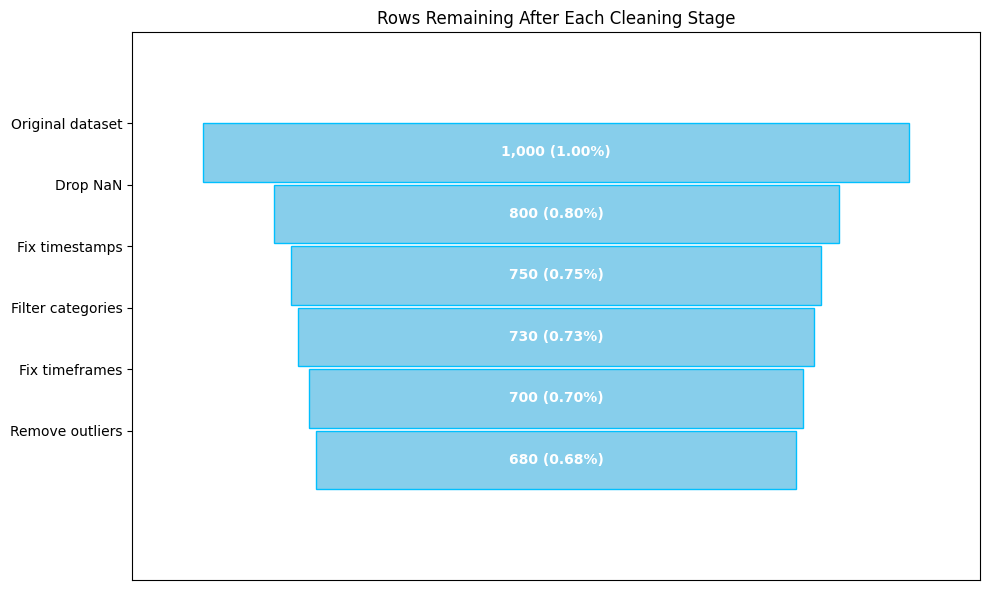

In [30]:
# plot parameters
fig, ax = plt.subplots(figsize=(10, 6))
ax: plt.Axes = ax

bar_height = 0.2
spacing = 0.01
y_val = (len(rows_remaining) - 1) * (bar_height + spacing)
min_width = 200
# loop to plot each bar and annotate it
for i, width in enumerate(rows_remaining):
    adjusted_width = max(width, min_width)
    
    ax.barh(y_val, adjusted_width, left=-adjusted_width/2, color="skyblue", edgecolor="deepskyblue", height=bar_height)
    # calculate percentage of remaining rows
    percentage = (width / original_count) * 100
    ax.text(0, y_val, f"{width:,} ({percentage:.2f}%)", va="center", ha="center", color="white", weight="bold")
    
    y_val -= (bar_height + spacing)
# formatting the plot
ax.set_xlim((-max(rows_remaining + [min_width])/2) * 1.2, (max(rows_remaining + [min_width])/2) * 1.2)
ax.set_ylim(0 - ((bar_height + spacing) + bar_height), len(rows_remaining) * (bar_height + spacing) + bar_height)
ax.set_yticks([(i * (bar_height + spacing)) + (bar_height / 2) for i in range(len(rows_remaining))])
ax.set_yticklabels(labels[::-1])
ax.set_xticks([])
ax.set_title("Rows Remaining After Each Cleaning Stage")

plt.tight_layout()
plt.savefig('./plots/filtration_steps.png', format='png', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Let's assume 'rows_remaining' and 'labels' are populated with the relevant data from your processing steps
rows_remaining = [1000, 800, 750, 730, 700, 680]  # Example data
rows_dropped = [rows_remaining[0] - count for count in rows_remaining[1:]] + [0]  # Calculate the number of rows dropped at each step
labels = ["Original dataset", "Drop NaN", "Fix timestamps", "Filter categories", "Fix timeframes", "Remove outliers"]  # Example labels

# Calculate the net change in data for the waterfall chart
net_change = [rows_remaining[0]] + [ -dropped for dropped in rows_dropped[:-1]]

# Create the base figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Initialize the starting point for the first bar
start = 0

# Loop through the net change and create each 'bar' of the waterfall
for index, value in enumerate(net_change):
    # Set the direction of the bar based on the change in data
    width = value
    # Set the color based on increase (green) or decrease (red) in data
    color = 'green' if value >= 0 else 'red'
    # Plot the bar
    ax.barh(labels[index], width, left=start, color=color)
    # Update the start position for the next bar
    start += width

# Add the last bar for the final count of rows remaining
ax.barh(labels[-1], rows_remaining[-1], left=0, color='blue')

# Invert the y-axis to have the original dataset at the top
ax.invert_yaxis()

# Add labels and title
ax.set_xlabel('Number of Rows')
ax.set_title('Data Remaining After Each Preprocessing Step')

# Remove y-ticks as we already have labels
ax.set_yticks([])

# Show grid only on the x-axis
ax.xaxis.grid(True)
ax.set_axisbelow(True)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataframes
processed_df = data_loader.processed_incidents_df
enhanced_df = data_loader.enhanced_incidents_df

# Convert 'time_call_received' to datetime in the processed dataframe
processed_df['time_call_received'] = pd.to_datetime(processed_df['time_call_received'])
enhanced_df['time_call_received'] = pd.to_datetime(enhanced_df['time_call_received'])

# Extract the date from 'time_call_received' for both dataframes
processed_df['date'] = processed_df['time_call_received'].dt.date
enhanced_df['date'] = enhanced_df['time_call_received'].dt.date

# Filter data for dates starting from January 1, 2015
start_date = pd.to_datetime('2015-01-01').date()
processed_df = processed_df[processed_df['date'] >= start_date]
enhanced_df = enhanced_df[enhanced_df['date'] >= start_date]

# Group by date and count the number of incidents for each date
processed_daily_counts = processed_df.groupby('date').size()
enhanced_daily_counts = enhanced_df.groupby('date').size()

# Now plot the two sets of counts
plt.figure(figsize=(14, 7))

# Plot for processed dataset
processed_daily_counts.plot(label='Processed Incidents', alpha=0.7)

# Plot for enhanced dataset
enhanced_daily_counts.plot(label='Enhanced Incidents', alpha=0.7)

plt.title('Daily Incidents After Cleaning Dataset')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.legend()
plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()


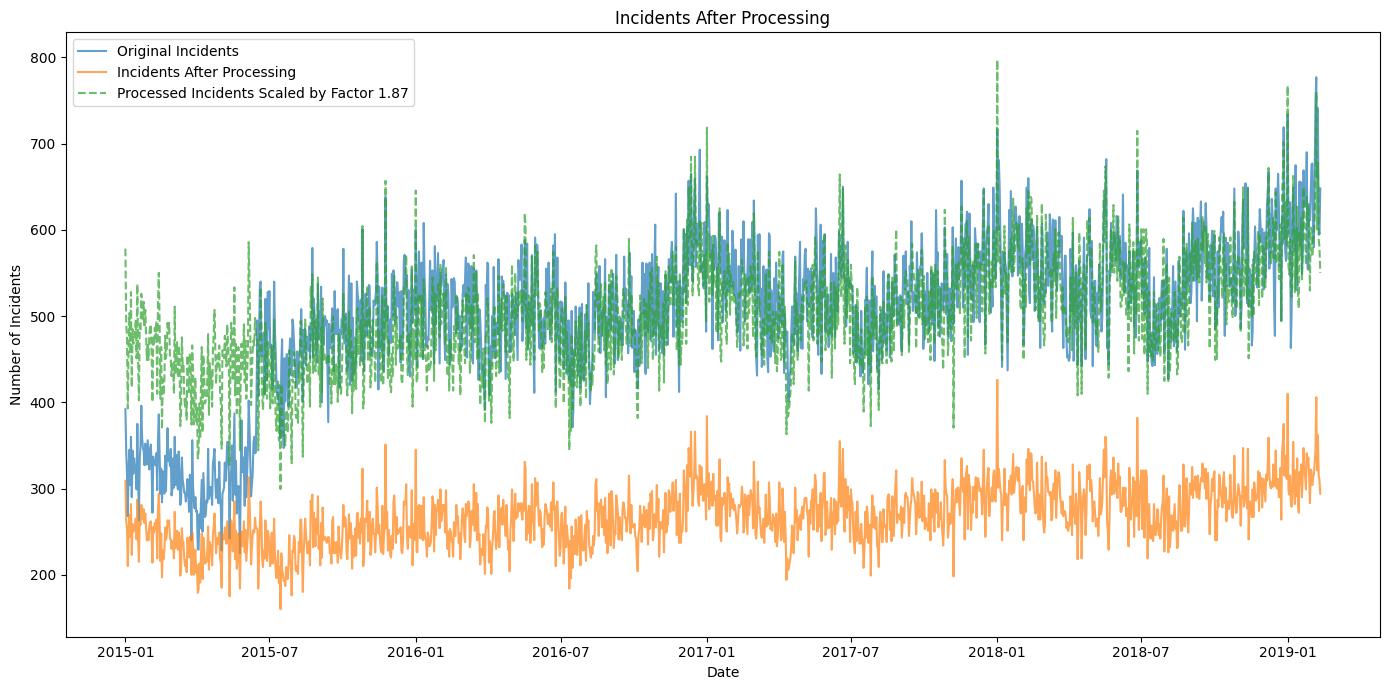

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the 'date' columns in both dataframes have already been created and filtered starting from January 1, 2015

# Calculate the total counts for each dataset
total_processed_incidents = processed_daily_counts.sum()
total_enhanced_incidents = enhanced_daily_counts.sum()

# Calculate the scaling factor
scaling_factor = total_processed_incidents / total_enhanced_incidents

# Create a new dataframe for the scaled enhanced dataset
enhanced_scaled_daily_counts = enhanced_daily_counts * scaling_factor

# Now plot the three sets of counts: processed, enhanced, and scaled enhanced
plt.figure(figsize=(14, 7))

# Plot for processed dataset
processed_daily_counts.plot(label='Original Incidents', alpha=0.7)

# Plot for enhanced dataset
enhanced_daily_counts.plot(label='Incidents After Processing', alpha=0.7)

# Plot for scaled enhanced dataset
enhanced_scaled_daily_counts.plot(label=f'Processed Incidents Scaled by Factor {scaling_factor:.2f}', linestyle='--', alpha=0.7)

plt.title('Incidents After Processing')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.legend()
plt.tight_layout()  # Adjust subplots to fit into figure area.

plt.savefig('./plots/incident_loss.png', format='png', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataframes (assuming this has been done already)
# processed_df = ...
# enhanced_df = ...

# Convert 'time_call_received' to datetime if needed and filter dates
processed_df['time_call_received'] = pd.to_datetime(processed_df['time_call_received'])
enhanced_df['time_call_received'] = pd.to_datetime(enhanced_df['time_call_received'])

# Filter the dataframes to include only data from January 1, 2015 onwards
start_date = '2015-01-01'
processed_df = processed_df[processed_df['time_call_received'].dt.date >= pd.to_datetime(start_date).date()]
enhanced_df = enhanced_df[enhanced_df['time_call_received'].dt.date >= pd.to_datetime(start_date).date()]

# Now create the daily counts for each dataframe
processed_daily_counts = processed_df['time_call_received'].dt.date.value_counts().sort_index()
enhanced_daily_counts = enhanced_df['time_call_received'].dt.date.value_counts().sort_index()

# Align the two series on their index (date) and calculate the daily scaling factor
# Note: days without enhanced incidents will create infinite or undefined factors; we'll avoid dividing by zero
scaling_factors = processed_daily_counts.div(enhanced_daily_counts.replace(0, np.nan))

# Plot the daily scaling factors
plt.figure(figsize=(14, 7))
scaling_factors.plot(marker='o', linestyle='-', color='blue')
plt.title('Daily Scaling Factor from Enhanced to Processed Incidents')
plt.xlabel('Date')
plt.ylabel('Scaling Factor')
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
def count_timestamp_discrepancies(df_incidents: pd.DataFrame) -> pd.DataFrame:
    time_columns = [
        'time_call_received', 'time_call_answered', 'time_ambulance_notified',
        'time_dispatch', 'time_arrival_scene', 'time_departure_scene',
        'time_arrival_hospital', 'time_available'
    ]

    # Convert time columns to datetime format if they are not already
    df_incidents[time_columns] = df_incidents[time_columns].apply(pd.to_datetime, errors='coerce')

    discrepancies = {}

    # Iterate over each pair of time columns
    for i in range(len(time_columns) - 1):
        col1, col2 = time_columns[i], time_columns[i + 1]
        # Count the rows where the time is out of order or the same
        discrepancies[f'{col1} to {col2}'] = df_incidents[(df_incidents[col1] > df_incidents[col2])].shape[0]

    discrepancies_df = pd.DataFrame(list(discrepancies.items()), columns=['Timeframe', 'Discrepancies'])
    return discrepancies_df

# Now let's use this function on the processed_df
discrepancies_df = count_timestamp_discrepancies(processed_df)
print(discrepancies_df)
discrepancies_df = count_timestamp_discrepancies(enhanced_df)
print(discrepancies_df)

                                        Timeframe  Discrepancies
0       time_call_received to time_call_answered          69700
1  time_call_answered to time_ambulance_notified           7688
2        time_ambulance_notified to time_dispatch             13
3             time_dispatch to time_arrival_scene             34
4      time_arrival_scene to time_departure_scene              2
5   time_departure_scene to time_arrival_hospital              2
6         time_arrival_hospital to time_available             34
                                        Timeframe  Discrepancies
0       time_call_received to time_call_answered              0
1  time_call_answered to time_ambulance_notified              0
2        time_ambulance_notified to time_dispatch              0
3             time_dispatch to time_arrival_scene              0
4      time_arrival_scene to time_departure_scene              0
5   time_departure_scene to time_arrival_hospital              0
6         time_arrival_hospit

In [ ]:
processed_df = data_loader.processed_incidents_df
enhanced_df = data_loader.enhanced_incidents_df

print(processed_df[(processed_df['response_time_sec'] > 0)]['response_time_sec'].median())
print(processed_df[(processed_df['response_time_sec'] > 0)]['response_time_sec'].mean())

print(processed_df['response_time_sec'].max())
print(processed_df['response_time_sec'].min())

print(enhanced_df['response_time_sec'].median())
print(enhanced_df['response_time_sec'].mean())

## Filtering Outliers By Z-Score
https://medium.com/clarusway/z-score-and-how-its-used-to-determine-an-outlier-642110f3b482

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def process_and_plot(df, title):
    # remove negative or zero response times and NaN values
    df = df[df['response_time_sec'] > 0].dropna(subset=['response_time_sec'])
    
    original_count = len(df)
    
    # log transformation
    df_log = np.log1p(df['response_time_sec'])
    
    # calculate mean and standard deviation
    mean_log = np.mean(df_log)
    std_log = np.std(df_log)
    
    # calculate Z-scores and remove outliers
    z_scores_log = (df_log - mean_log) / std_log
    z_score = 3
    df_log_filtered = df_log[np.abs(z_scores_log) <= z_score]
    
    # revert log transformation for the filtered data
    df_filtered = np.expm1(df_log_filtered)
    
    removed_rows = original_count - len(df_filtered)
    print(f"Rows removed with PDF filtering: {removed_rows}")
    
    # plotting
    plt.figure(figsize=(18, 6))
    plt.suptitle(title)
    
    # original data
    plt.subplot(1, 4, 1)
    plt.hist(df['response_time_sec'], bins=200, edgecolor='black', linewidth=0.2)
    plt.xlabel('Response Time (seconds)')
    plt.ylabel('Frequency')
    plt.title('Original Data')
    
    # original log-transformed data
    plt.subplot(1, 4, 2)
    plt.hist(df_log, bins=200, edgecolor='black', linewidth=0.2)
    plt.xlabel('Log(Response Time)')
    plt.ylabel('Frequency')
    plt.title('Original Log-Transformed Data')
    
    # filtered log-transformed data
    plt.subplot(1, 4, 3)
    plt.hist(df_log_filtered, bins=200, edgecolor='black', linewidth=0.2)
    plt.xlabel('Log(Response Time)')
    plt.ylabel('Frequency')
    plt.title(f'Filtered Log-Transformed Data (Z <= {z_score})')
    
    # filtered original scale data
    plt.subplot(1, 4, 4)
    plt.hist(df_filtered, bins=200, edgecolor='black', linewidth=0.2)
    plt.xlabel('Response Time (seconds)')
    plt.ylabel('Frequency')
    plt.title(f'Filtered Original Data (Z <= {z_score})')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    return df_filtered


df_processed = data_loader.processed_incidents_df
df_filtered1 = process_and_plot(df_processed, 'All Response Times')

df_high_priority = df_processed[df_processed['triage_impression_during_call'].isin(['A', 'U'])]
df_filtered2 = process_and_plot(df_high_priority, 'Acute and Urgent Response Times')

print(f"Shortest response time: {df_filtered2.min()}")
print(f"Longest response time: {df_filtered2.max()}")


## PDF Filtering

https://www.kaggle.com/code/faressayah/outlier-detection-using-pdf-and-z-score

In [ ]:
from scipy.stats import norm

def process_and_plot_pdf(df, title):
    # Remove negative values and NaNs
    df = df[df['response_time_sec'] > 0].dropna(subset=['response_time_sec'])
    
    original_count = len(df)
    
    # Convert seconds to minutes for analysis
    df['response_time_min'] = df['response_time_sec'] / 60.0
    df_log = np.log1p(df['response_time_min'])  # Log-transform the minutes
    
    # Calculate mean and standard deviation for log-transformed data
    mean_log = np.mean(df_log)
    std_log = np.std(df_log)
    
    # Calculate PDF values for each data point, set threshold and remove outliers
    pdf_values = norm.pdf(df_log, mean_log, std_log)
    pdf_threshold = 0.01
    df_log_filtered = df_log[pdf_values >= pdf_threshold]
    
    # Revert log transformation for the filtered data
    df_filtered = np.expm1(df_log_filtered)
    
    removed_rows = original_count - len(df_filtered)
    print(f"Rows removed with PDF filtering: {removed_rows}")

    # Plotting
    plt.figure(figsize=(12, 12))
    plt.suptitle(title)
    
    # Original data in minutes
    plt.subplot(2, 2, 1)
    plt.hist(df['response_time_min'], bins=300, edgecolor='black', linewidth=0.2)
    plt.xlabel('Response Time (minutes)')
    plt.ylabel('Frequency')
    plt.title('Original Data')
    
    # Original log-transformed data
    plt.subplot(2, 2, 2)
    plt.hist(df_log, bins=300, edgecolor='black', linewidth=0.2)
    plt.xlabel('Log(Response Time)')
    plt.ylabel('Frequency')
    plt.title('Original Log-Transformed Data')
    
    # Filtered log-transformed data
    plt.subplot(2, 2, 3)
    plt.hist(df_log_filtered, bins=300, edgecolor='black', linewidth=0.2)
    plt.xlabel('Log(Response Time)')
    plt.ylabel('Frequency')
    plt.title(f'Filtered Log-Transformed Data (PDF >= {pdf_threshold})')
    
    # Filtered original scale data converted back from minutes to seconds for consistency
    plt.subplot(2, 2, 4)
    plt.hist(df_filtered, bins=300, edgecolor='black', linewidth=0.2)  # Convert back to seconds
    plt.xlabel('Response Time (minutes)')
    plt.ylabel('Frequency')
    plt.title('Filtered Data in Original Scale')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('./plots/pdf_filtering.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

    return df_filtered * 60  # Convert minutes back to seconds for output

# Filter the dataframe for high priority incidents
df_processed = data_loader.processed_incidents_df
df_high_priority = df_processed[df_processed['triage_impression_during_call'].isin(['A', 'H'])]

#df_filtered_pdf = process_and_plot_pdf(df_processed, 'Response Times Based on PDF Filtering')
df_filtered_pdf_2 = process_and_plot_pdf(df_high_priority, 'Critical and High Priority Response Times')

print(f"Shortest response time: {df_filtered_pdf_2.min()} seconds")
print(f"Longest response time: {df_filtered_pdf_2.max()} seconds")

In [ ]:
# Filtered original scale data converted back from minutes to seconds for consistency
plt.subplot(1, 1, 1)
plt.hist(enhanced_df['response_time_sec'], bins=300, edgecolor='black', linewidth=0.2)  # Convert back to seconds
plt.xlabel('Response Time (minutes)')
plt.ylabel('Frequency')
plt.title('Filtered Data in Original Scale')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## How many rows have negative response times?

In [ ]:
df_processed = data_loader.processed_incidents_df.copy()
print(f"Negative response times: {df_processed[df_processed['response_time_sec'] < 0].shape[0]}")

## Quantile Representation of Response Times

In [ ]:
def generate_quantiles(num_quantiles):
    step = 1 / num_quantiles
    return [round(step * i, 2) for i in range(1, num_quantiles)] + [1.00]

### Five Percent Quantiles

In [ ]:
num_quantiles = 20

quantiles = df_processed['response_time_sec'].quantile(generate_quantiles(num_quantiles))
pd.set_option('display.float_format', lambda x: '%.2f' % x)
quantiles

In [ ]:
df_enhanced = data_loader.enhanced_incidents_df

quantiles = df_enhanced['response_time_sec'].quantile(generate_quantiles(num_quantiles))
pd.set_option('display.float_format', lambda x: '%.2f' % x)
quantiles

### Last Ten Percent in One-Percent Quantiles

In [ ]:
num_quantiles = 100

quantiles = df_processed['response_time_sec'].quantile(generate_quantiles(num_quantiles))
pd.set_option('display.float_format', lambda x: '%.2f' % x)
quantiles.tail(10)

In [ ]:
num_quantiles = 100

quantiles = df_enhanced['response_time_sec'].quantile(generate_quantiles(num_quantiles))
pd.set_option('display.float_format', lambda x: '%.2f' % x)
quantiles.tail(10)

## Mean, median and mode for positive time values

In [ ]:
stats_dict_good_values = {}

df_sample = data_loader.enhanced_incidents_df

time_columns = [
    'time_call_received', 'time_call_answered', 'time_ambulance_notified',
    'time_dispatch', 'time_arrival_scene', 'time_departure_scene',
    'time_arrival_hospital', 'time_available'
]
df_sample[time_columns] = df_sample[time_columns].apply(pd.to_datetime, errors='coerce', format="%Y.%m.%dT%H:%M:%S")
        
# loop through the columns and compare
for i in range(len(time_columns) - 1):
    col1 = time_columns[i]
    col2 = time_columns[i + 1]
    filtered_df_good = df_sample[df_sample[col1] <= df_sample[col2]]
    
    if not filtered_df_good.empty:
        # calculate the time difference in seconds
        time_diff_series_good = (filtered_df_good[col2] - filtered_df_good[col1]).dt.total_seconds()
        
        # calculate mean, median, and mode
        mean_time_diff_good = time_diff_series_good.mean()
        median_time_diff_good = time_diff_series_good.median()
        mode_time_diff_good = time_diff_series_good.mode()[0]  # taking the first mode

        # store the statistics in the dictionary
        stats_dict_good_values[f"{col1} <= {col2}"] = {
            'mean': mean_time_diff_good,
            'median': median_time_diff_good,
            'mode': mode_time_diff_good
        }

# display the statistics for "good" datetime values
stats_dict_good_values